# **COVID-19 Forecasting Using Deep Learning**

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import torch
import torch.nn as nn
import torch.optim as optim
import shutil
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm
from torch.utils.tensorboard import SummaryWriter
from darts.utils.statistics import check_seasonality, plot_acf
import darts.utils.timeseries_generation as tg
from darts import TimeSeries, concatenate
from darts.models import TCNModel, RNNModel, ExponentialSmoothing, BlockRNNModel
from darts.models import TransformerModel, NBEATSModel, TFTModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.metrics import mape, r2_score, mase, mae, marre, coefficient_of_variation, smape
from darts.utils.missing_values import fill_missing_values
from darts.utils.likelihood_models import GaussianLikelihood, PoissonLikelihood
from darts.utils.likelihood_models import NegativeBinomialLikelihood
from darts.dataprocessing.transformers import MissingValuesFiller

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

cases_data = pd.read_csv('https://raw.githubusercontent.com/biobotanalytics/covid19-wastewater-data/master/cases_by_county.csv')
viral_data = pd.read_csv('https://raw.githubusercontent.com/biobotanalytics/covid19-wastewater-data/master/wastewater_by_county.csv')
viral_data['date'] = viral_data['sampling_week']
penn_rest = pd.read_csv('https://raw.githubusercontent.com/mehrdadfazli/COVID-SEIR/main/Data/penn-rest.csv')
usa_facts = pd.read_csv('https://raw.githubusercontent.com/Shakeri-Lab/COVID-SEIR/main/Data/covid_confirmed_usafacts.csv')

train_test_ratio = 0.8
train_val_ratio  = 0.9

**Note:** Make sure to save the pretrained models on your machine and change the path to model checkpoints accordingly.

In [2]:
model_checkpoints_path = 'darts_logs/'

## **Utils**

In [3]:
def mape_calc(backtest_series, actual_series, transformer):
    return(mape(transformer.inverse_transform(actual_series),
                transformer.inverse_transform(backtest_series)))

def mae_calc(backtest_series, actual_series, transformer):
    return(mae(transformer.inverse_transform(actual_series),
                transformer.inverse_transform(backtest_series)))

def mase_calc(backtest_series, actual_series, insample_series, transformer):
    return(mase(transformer.inverse_transform(actual_series),
                transformer.inverse_transform(backtest_series), insample_series))

def r2_score_calc(backtest_series, actual_series, transformer):
    return(r2_score(transformer.inverse_transform(actual_series),
                transformer.inverse_transform(backtest_series)))

def marre_calc(backtest_series, actual_series, transformer):
    return(marre(transformer.inverse_transform(actual_series),
                transformer.inverse_transform(backtest_series)))

def cov_calc(backtest_series, actual_series, transformer):
    return(coefficient_of_variation(transformer.inverse_transform(actual_series),
                transformer.inverse_transform(backtest_series)))

def smape_calc(backtest_series, actual_series, transformer):
    return(smape(transformer.inverse_transform(actual_series),
                transformer.inverse_transform(backtest_series)))

In [4]:
from typing import Dict, List, Optional

import matplotlib.pyplot as plt
import pandas as pd
from torch import Tensor

from darts import TimeSeries
from darts.explainability.explainability import (
    ExplainabilityResult,
    ForecastingModelExplainer,
)
from darts.models import TFTModel
from pytorch_lightning.callbacks import Callback


class TFTExplainer(ForecastingModelExplainer):
    def __init__(
        self,
        model: TFTModel,
    ):
        """
        Explainer class for the TFT model.
        Parameters
        ----------
        model
            The fitted TFT model to be explained.
        """
        super().__init__(model)

        if not model._fit_called:
            raise ValueError("The model needs to be trained before explaining it.")

        self._model = model

    @property
    def encoder_importance(self):
        return self._get_importance(self,
            weight=self._model.model._encoder_sparse_weights,
            names=self._model.model.encoder_variables,
        )

    @property
    def decoder_importance(self):
        return self._get_importance(self,
            weight=self._model.model._decoder_sparse_weights,
            names=self._model.model.decoder_variables,
        )

    def get_variable_selection_weight(self, plot=False) -> Dict[str, pd.DataFrame]:
        """Returns the variable selection weight of the TFT model.
        Parameters
        ----------
        plot
            Whether to plot the variable selection weight.
        Returns
        -------
        TimeSeries
            The variable selection weight.
        """

        if plot:
            # plot the encoder and decoder weights
            self._plot_cov_selection(
                self.encoder_importance,
                title="Encoder variable importance",
            )
            self._plot_cov_selection(
                self.decoder_importance,
                title="Decoder variable importance",
            )

        return {
            "encoder_importance": self.encoder_importance,
            "decoder_importance": self.decoder_importance,
        }

    def explain(self, **kwargs) -> ExplainabilityResult:
        """Returns the explainability result of the TFT model.
        The explainability result contains the attention heads of the TFT model.
        The attention heads determine the contribution of time-varying inputs.
        Parameters
        ----------
        kwargs
            Arguments passed to the `predict` method of the TFT model.
        Returns
        -------
        ExplainabilityResult
            The explainability result containing the attention heads.
        """
        super().explain()
        # without the predict call, the weights will still bet set to the last iteration of the forward() method
        # of the _TFTModule class
        if "n" not in kwargs:
            kwargs["n"] = self._model.model.output_chunk_length

        _ = self._model.predict(**kwargs)

        # get the weights and the attention head from the trained model for the prediction
        attention_heads = (
            self._model.model._attn_out_weights.squeeze().sum(axis=1).detach()
        )

        # return the explainer result to be used in other methods
        return ExplainabilityResult(
            {
                0: {
                    "attention_heads": TimeSeries.from_dataframe(
                        pd.DataFrame(attention_heads).transpose()
                    ),
                }
            },
        )

    @staticmethod
#     def plot_attention_heads(
#         expl_result: ExplainabilityResult,
#         plot_type: Optional[Literal["all", "time", "heatmap"]] = "time",
#     ):
#         """Plots the attention heads of the TFT model."""
#         attention_heads = expl_result.get_explanation(
#             component="attention_heads",
#             horizon=0,
#         )
#         if plot_type == "all":
#             fig = plt.figure()
#             attention_heads.plot(
#                 label="Attention Head",
#                 plot_all_components=True,
#                 figure=fig,
#             )
#             # move legend to the right side of the figure
#             plt.legend(bbox_to_anchor=(0.95, 1), loc="upper left")
#             plt.xlabel("Time steps in past")
#             plt.ylabel("Attention")
#         elif plot_type == "time":
#             fig = plt.figure()
#             attention_heads.mean(1).plot(label="Mean Attention Head", figure=fig)
#             plt.xlabel("Time steps in past")
#             plt.ylabel("Attention")
#         elif plot_type == "heatmap":
#             avg_attention = attention_heads.values().transpose()
#             fig = plt.figure()
#             plt.imshow(avg_attention, cmap="hot", interpolation="nearest", figure=fig)
#             plt.xlabel("Time steps in past")
#             plt.ylabel("Horizon")
#         else:
#             raise ValueError("`plot_type` must be either 'all', 'time' or 'heatmap'")

    def _get_importance(
        self,
        weight: Tensor,
        names: List[str],
        n_decimals=3,
    ) -> pd.DataFrame:
        """Returns the encoder or decoder variable of the TFT model.
        Parameters
        ----------
        weights
            The weights of the encoder or decoder of the trained TFT model.
        names
            The encoder or decoder names saved in the TFT model class.
        n_decimals
            The number of decimals to round the importance to.
        Returns
        -------
        pd.DataFrame
            The importance of the variables.
        """
        # transform the encoder/decoder weights to percentages, rounded to n_decimals
        weights_percentage = (
            weight.mean(axis=1).detach().numpy().mean(axis=0).round(n_decimals) * 100
        )

        # create a dataframe with the variable names and the weights
        name_mapping = self._name_mapping
        importance = pd.DataFrame(
            weights_percentage,
            columns=[name_mapping[name] for name in names],
        )

        # return the importance sorted descending
        return importance.transpose().sort_values(0, ascending=False).transpose()

    @property
    def _name_mapping(self) -> Dict[str, str]:
        """Returns the feature name mapping of the TFT model.
        Returns
        -------
        Dict[str, str]
            The feature name mapping. For example
            {
                'past_covariate_0': 'heater',
                'past_covariate_1': 'year',
                'past_covariate_2': 'month',
                'future_covariate_0': 'darts_enc_fc_cyc_month_sin',
                'future_covariate_1': 'darts_enc_fc_cyc_month_cos',
                'target_0': 'ice cream',
             }
        """
        past_covariates_name_mapping = {
            f"past_covariate_{i}": colname
            for i, colname in enumerate(self._model.past_covariate_series.components)
        }
        future_covariates_name_mapping = {
            f"future_covariate_{i}": colname
            for i, colname in enumerate(self._model.future_covariate_series.components)
        }
        target_name_mapping = {
            f"target_{i}": colname
            for i, colname in enumerate(self._model.training_series.components)
        }

        return {
            **past_covariates_name_mapping,
            **future_covariates_name_mapping,
            **target_name_mapping,
        }

    @staticmethod
    def _plot_cov_selection(
        importance: pd.DataFrame, title: str = "Variable importance"
    ):
        """Plots the variable importance of the TFT model.
        Parameters
        ----------
        importance
            The encoder / decoder importance.
        title
            The title of the plot.
        """
        fig = plt.figure()
        plt.bar(importance.columns.tolist(), importance.values[0].tolist(), figure=fig)
        plt.title(title)
        plt.xlabel("Variable", fontsize=12)
        plt.ylabel("Variable importance in %")
        plt.show()

class LossLogger(Callback):
    def __init__(self):
        self.train_loss = []
        self.val_loss = []

    def on_train_epoch_end(self, trainer: "pl.Trainer", pl_module: "pl.LightningModule") -> None:
        self.train_loss.append(float(trainer.callback_metrics["train_loss"]))

    def on_validation_epoch_end(self, trainer: "pl.Trainer", pl_module: "pl.LightningModule") -> None:
        self.val_loss.append(float(trainer.callback_metrics["val_loss"]))

## **County Class**
Here we define a county class which stores all the information on a county-level including cases, viral load data and covariates. The set_timeseries method scales, fills in missing values, and splits the time series into train and test.

In [5]:
class county:
  
    def __init__(self, county):
        self.county = county

    def set_timeseries(self, cases, viral, covars, end_date=None, fill_daily=False):
        
        if fill_daily:
            fill_frq = 'D'
        else:
            fill_frq = 'W-WED'
        
        if not end_date:
            end_date = dt.datetime.today()

        self.state = cases.loc[cases['name'] == self.county]['state'].values[0]

        cases_df = cases.loc[cases['name'] == self.county]
        viral_df = viral.loc[viral['name'] == self.county]
        covars_df = covars.loc[covars['state'] == self.state]

        self.date = list(set(list(cases_df['date'])) & set(list(covars_df['date'])))

        cases_df  = cases_df.loc[cases_df['date'].isin(self.date)]
        viral_df  = viral_df.loc[viral_df['date'].isin(self.date)]
        covars_df = covars_df.loc[covars_df['date'].isin(self.date)]
        
        covars_df['date']= pd.to_datetime(covars_df['date'])
        cases_df['date'] = pd.to_datetime(cases_df['date'])
        viral_df['date'] = pd.to_datetime(viral_df['date'])
        
        cases_df = cases_df.loc[(cases_df['date'] >= min(viral_df['date'])) & 
                                (cases_df['date'] <= max(viral_df['date'])) &
                                (cases_df['date'] < end_date)]
        covars_df = covars_df.loc[(covars_df['date'] >= min(viral_df['date'])) &
                                  (covars_df['date'] < end_date)]
        viral_df = viral_df.loc[(viral_df['date'] < end_date)]

        covars_df = covars_df.set_index('date')
        cases_df['date'] = pd.to_datetime(cases_df['date'])
        cases_df = cases_df.set_index('date')

        viral_df = viral_df.set_index('date')    

        self.cases         = TimeSeries.from_series(cases_df['rolling_average_cases_per_100k_centered'], fill_missing_dates=True, freq=fill_frq)
        self.cases_scalers = Scaler()
        self.cases_transformer = MissingValuesFiller()
        self.cases_scaled  = self.cases_scalers.fit_transform(self.cases_transformer.transform(self.cases))
        self.cases_scaled_train, self.cases_scaled_test = self.cases_scaled.split_after(train_test_ratio)
        self.cases_scaled_train, self.cases_scaled_val  = self.cases_scaled_train.split_after(train_val_ratio)


        self.viral         = TimeSeries.from_series(viral_df['effective_concentration_rolling_average'], fill_missing_dates=True, freq=fill_frq)
        self.viral_scalers = Scaler()
        self.viral_transformer = MissingValuesFiller()
        self.viral_scaled  = self.viral_scalers.fit_transform(self.viral_transformer.transform(self.viral))
        self.viral_scaled_train, self.viral_scaled_test = self.viral_scaled.split_after(train_test_ratio)
        self.viral_scaled_train, self.viral_scaled_val  = self.viral_scaled_train.split_after(train_val_ratio)

        stringency_ts      = TimeSeries.from_series(covars_df['StringencyIndex_Average'], fill_missing_dates=True, freq=fill_frq)
        govresp_ts         = TimeSeries.from_series(covars_df['GovernmentResponseIndex_Average'], fill_missing_dates=True, freq=fill_frq)
        containH_ts        = TimeSeries.from_series(covars_df['ContainmentHealthIndex_Average'], fill_missing_dates=True, freq=fill_frq)
        econSupp_ts        = TimeSeries.from_series(covars_df['EconomicSupportIndex'], fill_missing_dates=True, freq=fill_frq)
        
        self.covars = govresp_ts.stack(stringency_ts).stack(containH_ts).stack(econSupp_ts)
        
        year_covar    = (datetime_attribute_timeseries(self.covars, attribute="year", one_hot=False)-2020)/2
        month_covar   = datetime_attribute_timeseries(self.covars, attribute="month", one_hot=False)/12
        week_covar    = datetime_attribute_timeseries(self.covars, attribute="week", one_hot=False)/52
        dayOfW_covar  = datetime_attribute_timeseries(self.covars, attribute="dayofweek", one_hot=False)/6

        self.covars = self.covars.stack(year_covar).stack(month_covar).stack(week_covar).stack(dayOfW_covar)
        covars_transformer = MissingValuesFiller()
        self.covars = covars_transformer.transform(self.covars)

## **Covariates**

Now we can add covariates including government responses, stringency index, and econimic support. The data is collected by the University of Oxford [here](https://github.com/OxCGRT/covid-policy-tracker).

In [6]:
oxford_covar = pd.read_csv('https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/United%20States/OxCGRT_USA_latest.csv')
oxford_covar = oxford_covar[['Date', 'RegionName', 'RegionCode', 'StringencyIndex_Average', 
                            'GovernmentResponseIndex_Average', 'ContainmentHealthIndex_Average', 
                             'EconomicSupportIndex']]

oxford_covar = oxford_covar.astype({'Date': str})
oxford_covar['date'] = oxford_covar['Date'].apply(lambda L: L[:4] + '-' + L[4:6] + '-' + L[6:])
oxford_covar['StringencyIndex_Average'] /= 100
oxford_covar['GovernmentResponseIndex_Average'] /= 100
oxford_covar['ContainmentHealthIndex_Average'] /= 100
oxford_covar['EconomicSupportIndex'] /= 100

oxford_covar = oxford_covar.dropna(subset=['RegionCode'])
oxford_covar['state'] = oxford_covar['RegionCode'].apply(lambda L: L[3:])

Now we select the counties we want to include in our analysis

In [7]:
target_counties = ['Nantucket County, MA', 'Dauphin County, PA',    'Elko County, NV', 
                   'Arapahoe County, CO',  'Erie County, PA',       'Indiana County, PA', 
                   'Jefferson County, KY', 'Miami-Dade County, FL', 'Suffolk County, MA', 
                   'Essex County, MA',     'Hampshire County, MA',  'Union County, NJ', 
                   'Lake County, IN']
end_dates = [dt.datetime.fromisoformat('2022-05-01'), dt.datetime.fromisoformat('2022-12-05'), dt.datetime.fromisoformat('2022-03-18'), 
             dt.datetime.fromisoformat('2022-04-15'), dt.datetime.fromisoformat('2022-12-05'), dt.datetime.fromisoformat('2022-06-01'), 
             dt.datetime.fromisoformat('2022-06-01'), dt.datetime.fromisoformat('2022-03-18'), dt.datetime.fromisoformat('2022-12-05'),
             dt.datetime.fromisoformat('2022-12-05'), dt.datetime.fromisoformat('2022-07-01'), dt.datetime.fromisoformat('2022-12-05'), 
             dt.datetime.fromisoformat('2022-04-01')]

counties_instances = []

for i in range(len(target_counties)):
    print(target_counties[i])
    counties_instances.append(county(target_counties[i]))
    counties_instances[i].set_timeseries(cases_data, viral_data, oxford_covar, end_dates[i], fill_daily=True)

print(len(target_counties), len(end_dates))

Nantucket County, MA
Dauphin County, PA
Elko County, NV
Arapahoe County, CO
Erie County, PA
Indiana County, PA
Jefferson County, KY
Miami-Dade County, FL
Suffolk County, MA
Essex County, MA
Hampshire County, MA
Union County, NJ
Lake County, IN
13 13


Now we make a list of training and covariate timeseries

In [8]:
# with viral load

train_list_ts = []
val_list_ts   = []
test_list_ts  = []
past_covar_ts = []
fut_covar_ts  = []
past_only_covar_ts = []
full_ts = []
county_names = []

for i in range(len(target_counties)):
    county_names.append(counties_instances[i].county[:-11])
    full_ts.append(counties_instances[i].cases_scaled)
    train_list_ts.append(counties_instances[i].cases_scaled_train)
    val_list_ts.append(counties_instances[i].cases_scaled_val)
    test_list_ts.append(counties_instances[i].cases_scaled_test)
    fut_covar_ts.append(counties_instances[i].covars)
    past_only_covar_ts.append(counties_instances[i].viral_scaled)
    past_covar_ts.append(counties_instances[i].covars.split_before(len(counties_instances[i].viral_scaled))[0].stack(counties_instances[i].viral_scaled))

## Visualization of the processed data

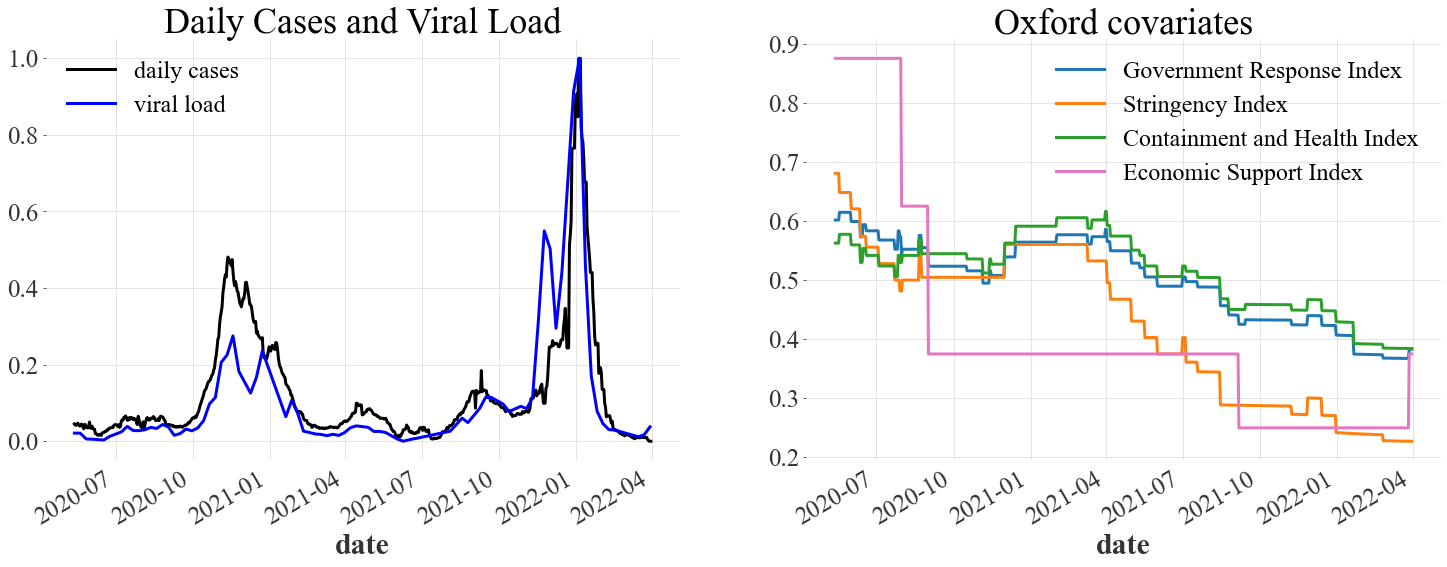

In [13]:
k=12
fig, axes = plt.subplots(1, 2, figsize = (25, 9))
plt.rcParams.update({'font.size': 30, 'font.weight':'normal', 'font.family': 'times new roman'})
plt.subplots_adjust(left=None, bottom=0.15, right=None, top=0.8, wspace=None, hspace=0.4)

counties_instances[k].cases_scaled.plot(label='Daily Cases', ax=axes[0], linewidth=3, color='black')
counties_instances[k].viral_scaled.plot(label='Viral Load',  ax=axes[0], linewidth=3, color='blue')
axes[0].set_title('Daily Cases and Viral Load')
axes[0].legend(['daily cases', 'viral load'], fontsize=24)

# plt.figure(figsize=(15, 10))
counties_instances[k].covars['GovernmentResponseIndex_Average'].plot(label='Government Response Index', ax=axes[1], color='tab:blue', linewidth=3)
counties_instances[k].covars['StringencyIndex_Average'].plot(label='Stringency Index', ax=axes[1], color='tab:orange', linewidth=3)
counties_instances[k].covars['ContainmentHealthIndex_Average'].plot(label='Containment and Health Index', ax=axes[1], color='tab:green', linewidth=3)
counties_instances[k].covars['EconomicSupportIndex'].plot(label='Economic Support Index', ax=axes[1], color='tab:pink', linewidth=3)
axes[1].set_title('Oxford covariates')
axes[1].legend(['Government Response Index', 'Stringency Index', 'Containment and Health Index', 'Economic Support Index'], fontsize=24)

plt.gcf().subplots_adjust(bottom=0.15)

# fig.suptitle(counties_instances[k].county, fontsize=40)plt.savefig('./figs/TFT/Jan-10/viral.png', bbox_inches='tight', dpi=300)
# plt.gcf().subplots_adjust(bottom=0.15)

Text(0.5, 0.98, 'Jefferson County, KY')

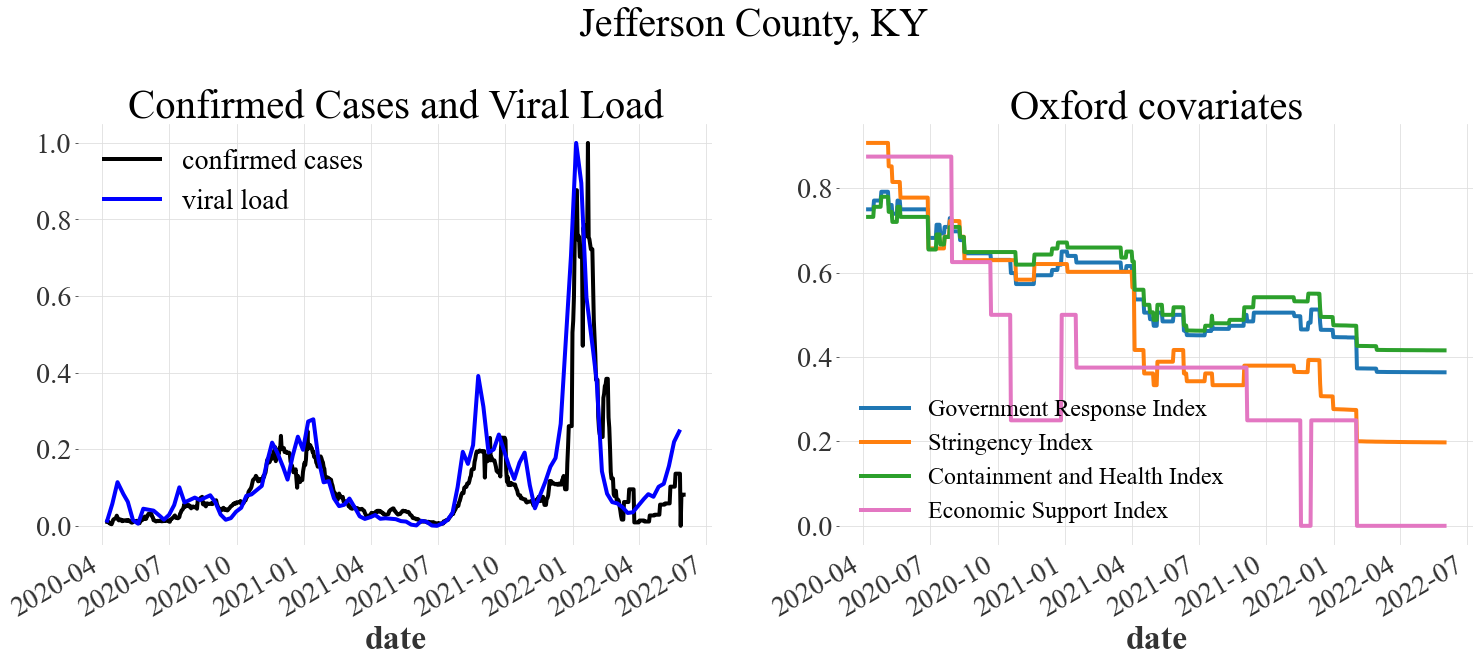

In [16]:
k=6
fig, axes = plt.subplots(1, 2, figsize = (25, 9))
plt.rcParams.update({'font.size': 34, 'font.weight':'normal', 'font.family': 'times new roman'})
plt.subplots_adjust(left=None, bottom=0.15, right=None, top=0.8, wspace=None, hspace=0.4)

counties_instances[k].cases_scaled.plot(label='Confirmed Cases', ax=axes[0], linewidth=4, color='black')
counties_instances[k].viral_scaled.plot(label='Viral Load',  ax=axes[0], linewidth=4, color='blue')
axes[0].set_title('Confirmed Cases and Viral Load')
axes[0].legend(['confirmed cases', 'viral load'], fontsize=28)

# plt.figure(figsize=(15, 10))
counties_instances[k].covars['GovernmentResponseIndex_Average'].plot(label='Government Response Index', ax=axes[1], color='tab:blue', linewidth=4)
counties_instances[k].covars['StringencyIndex_Average'].plot(label='Stringency Index', ax=axes[1], color='tab:orange', linewidth=4)
counties_instances[k].covars['ContainmentHealthIndex_Average'].plot(label='Containment and Health Index', ax=axes[1], color='tab:green', linewidth=4)
counties_instances[k].covars['EconomicSupportIndex'].plot(label='Economic Support Index', ax=axes[1], color='tab:pink', linewidth=4)
axes[1].set_title('Oxford covariates')
axes[1].legend(['Government Response Index', 'Stringency Index', 'Containment and Health Index', 'Economic Support Index'], fontsize=24, loc='lower left')

plt.gcf().subplots_adjust(bottom=0.15)

fig.suptitle(counties_instances[k].county, fontsize=40)

# Modeling

We use [Darts](https://unit8co.github.io/darts/index.html) package to train [DeepTCN](https://arxiv.org/abs/1906.04397) and [TFT](https://arxiv.org/abs/1912.09363) models.

## **DeepTCN** with viral load

Check out the [documentation](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.tcn_model.html) of the TCNModel for more information about the parameters.

In [17]:
# if you want to retrain the models you just have to uncomment the lines below and train you model. Otherwise just run the last line.

# loss_logger_deeptcn = LossLogger()

# deeptcn = TCNModel(
#     input_chunk_length=30,
#     output_chunk_length=10,
#     num_layers=3,
#     kernel_size=5,
#     num_filters=10,
#     dilation_base=2,
#     dropout=0.2,
#     random_state=0,
#     batch_size=16,
#     n_epochs=100,
#     optimizer_kwargs={'lr':1e-3},
#     likelihood=GaussianLikelihood(),
#     nr_epochs_val_period=1,
#     pl_trainer_kwargs={'callbacks': [loss_logger_deeptcn]},
#     model_name='DeepTCN-with-covars',
#     force_reset=True,
#     save_checkpoints=True
# )

# deeptcn.fit(series=train_list_ts,
#             val_series=val_list_ts,
#             past_covariates=past_covar_ts,
#             val_past_covariates=past_covar_ts,
#             num_loader_workers=4,
#             verbose=True)

# if you want to use the pretrained model you just need to save them from GitHub repo to your machine and run the line below

deeptcn = TCNModel.load_from_checkpoint(work_dir=model_checkpoints_path, model_name='DeepTCN-with-covars', best=True)

## **DeepTCN** without viral load

In [18]:
# if you want to retrain the models you just have to uncomment the lines below and train you model. Otherwise just run the last line.

# loss_logger_deeptcn_wo_V = LossLogger()

# deeptcn_wo_V = TCNModel(
#     input_chunk_length=30,
#     output_chunk_length=10,
#     num_layers=3,
#     kernel_size=5,
#     num_filters=10,
#     dilation_base=2,
#     dropout=0.2,
#     random_state=42,
#     batch_size=16,
#     n_epochs=50,
# #     optimizer_kwargs={'lr':5e-4},
#     likelihood=GaussianLikelihood(),
#     nr_epochs_val_period=1,
#     pl_trainer_kwargs={'callbacks': [loss_logger_deeptcn_wo_V]},
#     model_name='DeepTCN-without-viral',
#     force_reset=True,
#     save_checkpoints=True
# )

# deeptcn_wo_V.fit(series=train_list_ts,
#             val_series=val_list_ts,
#             past_covariates=fut_covar_ts,
#             val_past_covariates=fut_covar_ts,
#             num_loader_workers=2,
#             verbose=True)

# if you want to use the pretrained model you just need to save them from GitHub repo to your machine and run the line below

deeptcn_wo_V = TCNModel.load_from_checkpoint(model_name='DeepTCN-without-viral', best=True)

## **TFT** with viral load

Check out the [documentation](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.tft_model.html) of the TFTModel for more information about the parameters.

In [19]:
# if you want to retrain the models you just have to uncomment the lines below and train you model. Otherwise just run the last line.

# loss_logger_tft = LossLogger()

# tft = TFTModel(
#     input_chunk_length=30,
#     output_chunk_length=10,
#     hidden_size=16,
#     lstm_layers=1,
#     batch_size=64,
#     n_epochs=200,
#     dropout=0.3,
#     add_relative_index=False,
#     optimizer_kwargs={"lr": 1e-3},
#     random_state=0,
# #     likelihood=GaussianLikelihood(),
#     nr_epochs_val_period=1,
#     pl_trainer_kwargs={"callbacks": [loss_logger_tft]},
#     model_name='TFT-with-covars',
#     force_reset=True,
#     save_checkpoints=True
# )

# # fit the model with past and future covariates
# tft.fit(
#     series               = train_list_ts,
#     val_series           = val_list_ts,
#     future_covariates    = fut_covar_ts,
#     past_covariates      = past_only_covar_ts,
#     val_future_covariates= fut_covar_ts,
#     val_past_covariates  = past_only_covar_ts,
#     num_loader_workers   = 4,
#     verbose=True
# )

# if you want to use the pretrained model you just need to save them from GitHub repo to your machine and run the line below

tft = TFTModel.load_from_checkpoint(model_name='TFT-with-covars', best=True)

## **TFT** without viral load

In [20]:
# if you want to retrain the models you just have to uncomment the lines below and train you model. Otherwise just run the last line.

# loss_logger_tft_wo_V = LossLogger()

# tft_wo_V = TFTModel(
#     input_chunk_length=30,
#     output_chunk_length=10,
#     hidden_size=16,
#     lstm_layers=1,
#     batch_size=64,
#     n_epochs=200,
#     dropout=0.3,
#     add_relative_index=False,
#     optimizer_kwargs={"lr": 2e-4},
#     random_state=42,
# #     likelihood=GaussianLikelihood(),
#     nr_epochs_val_period=1,
#     pl_trainer_kwargs={"callbacks": [loss_logger_tft_wo_V]},
#     model_name='TFT-without-viral',
#     force_reset=True,
#     save_checkpoints=True
# )

# # fit the model with past and future covariates
# tft_wo_V.fit(
#     series               = train_list_ts,
#     val_series           = val_list_ts,
#     future_covariates    = fut_covar_ts,
#     val_future_covariates= fut_covar_ts,
#     num_loader_workers   = 2,
#     verbose=True
# )

# if you want to use the pretrained model you just need to save them from GitHub repo to your machine and run the line below

tft_wo_V = TFTModel.load_from_checkpoint(model_name='TFT-without-viral', best=True)

# Model evaluation

## Prediction

We first try predicting daily cases for the duration of the test period (over 100 days for some counties). In this case, models perform predictions for the first forecast horizon (`output_chunk_length`) which is 10 days. Then, it uses the predicted value for the first forecast horizon to make prediction for the second forecast horizon and so on. It is worth mentioning that the model does not have access to the past covariates past the training period.

In [21]:
n_samples = 100
low_q = 0.05
high_q = 0.95

smape_dict = {'TFT':[], 'TFT_noV':[], 'DeepTCN':[], 'DeepTCN_noV':[]}
mae_dict   = {'TFT':[], 'TFT_noV':[], 'DeepTCN':[], 'DeepTCN_noV':[]}

pred_tft          = []
pred_tft_noV      = []
pred_deeptcn      = []
pred_deeptcn_wo_V = []

for i in range(13):
    print('County {}, {}/13'.format(counties_instances[i].county, i+1))
    n_days_pred = len(counties_instances[i].cases_scaled_test)
    
    pred_tft.append(tft.predict(n_days_pred, series=counties_instances[i].cases_scaled_val, past_covariates=past_only_covar_ts[i], future_covariates=fut_covar_ts[i], num_samples=n_samples))
    pred_tft_noV.append(tft_wo_V.predict(n_days_pred, series=counties_instances[i].cases_scaled_val, future_covariates=fut_covar_ts[i], num_samples=n_samples))
    pred_deeptcn.append(deeptcn.predict(n_days_pred, series=counties_instances[i].cases_scaled_val, past_covariates=past_covar_ts[i], num_samples=n_samples))
    pred_deeptcn_wo_V.append(deeptcn_wo_V.predict(n_days_pred, series=counties_instances[i].cases_scaled_val, past_covariates=fut_covar_ts[i], num_samples=n_samples))

    smape_dict['TFT'].append(smape_calc(counties_instances[i].cases_scaled_test, pred_tft[i], counties_instances[i].cases_scalers))
    mae_dict['TFT'].append(mae_calc(counties_instances[i].cases_scaled_test, pred_tft[i], counties_instances[i].cases_scalers))
    
    smape_dict['TFT_noV'].append(smape_calc(counties_instances[i].cases_scaled_test, pred_tft_noV[i], counties_instances[i].cases_scalers))
    mae_dict['TFT_noV'].append(mae_calc(counties_instances[i].cases_scaled_test, pred_tft_noV[i], counties_instances[i].cases_scalers))

    smape_dict['DeepTCN'].append(smape_calc(counties_instances[i].cases_scaled_test, pred_deeptcn[i], counties_instances[i].cases_scalers))
    mae_dict['DeepTCN'].append(mae_calc(counties_instances[i].cases_scaled_test, pred_deeptcn[i], counties_instances[i].cases_scalers))

    smape_dict['DeepTCN_noV'].append(smape_calc(counties_instances[i].cases_scaled_test, pred_deeptcn_wo_V[i], counties_instances[i].cases_scalers))
    mae_dict['DeepTCN_noV'].append(mae_calc(counties_instances[i].cases_scaled_test, pred_deeptcn_wo_V[i], counties_instances[i].cases_scalers))

County Nantucket County, MA, 1/13


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

County Dauphin County, PA, 2/13


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

County Elko County, NV, 3/13


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

County Arapahoe County, CO, 4/13


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

County Erie County, PA, 5/13


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

County Indiana County, PA, 6/13


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

County Jefferson County, KY, 7/13


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

County Miami-Dade County, FL, 8/13


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

County Suffolk County, MA, 9/13


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

County Essex County, MA, 10/13


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

County Hampshire County, MA, 11/13


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

County Union County, NJ, 12/13


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

County Lake County, IN, 13/13


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

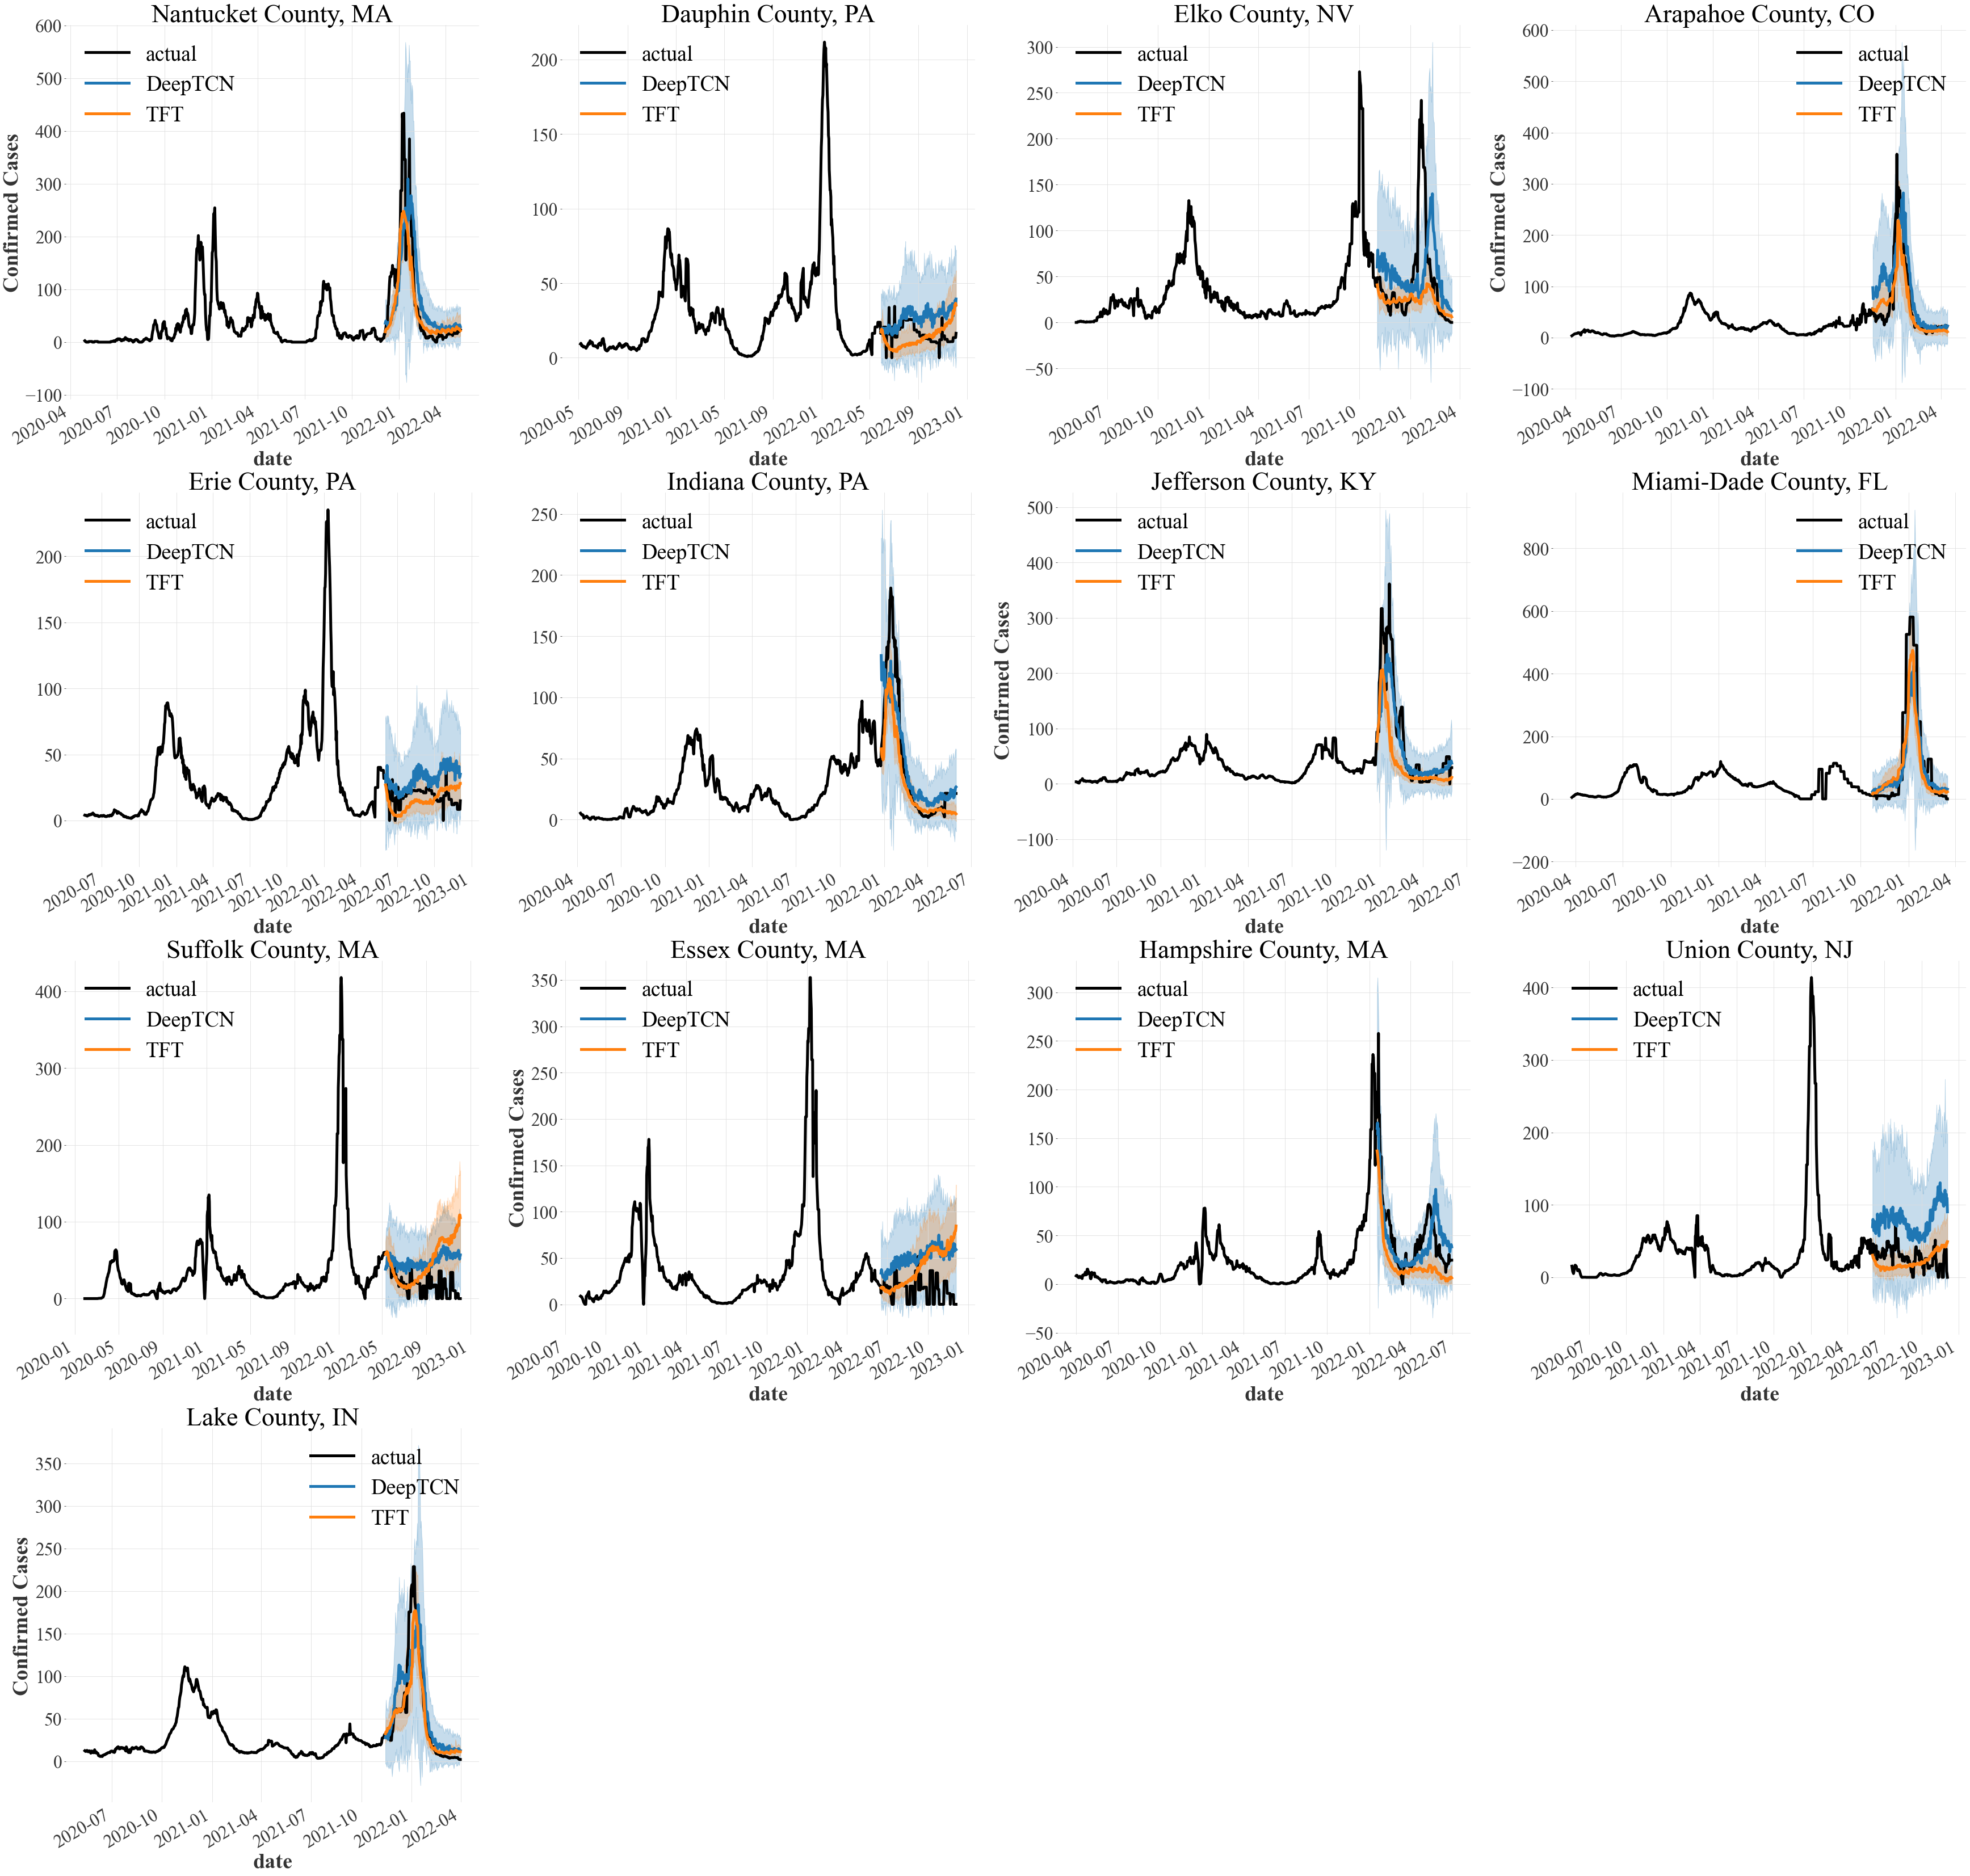

In [22]:
fig=plt.figure(figsize=[60, 60])
plt.rcParams.update({'font.family':'times new roman', 'font.size': 38, 'font.weight':'normal'})

for i in range(13):
    axis = fig.add_subplot(4,4,i+1)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=0.85, wspace=None, hspace=0.25)
    
    counties_instances[i].cases_scalers.inverse_transform(counties_instances[i].cases_scaled).plot(label="actual", ax=axis, linewidth=5)
    counties_instances[i].cases_scalers.inverse_transform(pred_deeptcn[i]).plot(label="DeepTCN", low_quantile=low_q, high_quantile=high_q, c='tab:blue', ax=axis, linewidth=5)
    counties_instances[i].cases_scalers.inverse_transform(pred_tft[i]).plot(label="TFT", low_quantile=low_q, high_quantile=high_q, c='tab:orange', ax=axis, linewidth=5)
    
    axis.legend()
    axis.set_title(counties_instances[i].county)
    
    if i%3 == 0:
        axis.set_ylabel('Confirmed Cases')

plt.show()

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

TFT - SMAPE:  54.18810241039998
TFT no viral - SMAPE:  96.58509992305345


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

TFT - SMAPE:  31.646044651841944
TFT no viral - SMAPE:  78.32672490655752


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

TFT - SMAPE:  39.92235542216116
TFT no viral - SMAPE:  76.52813121094434


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

TFT - SMAPE:  81.58941403623254
TFT no viral - SMAPE:  97.9396906179023


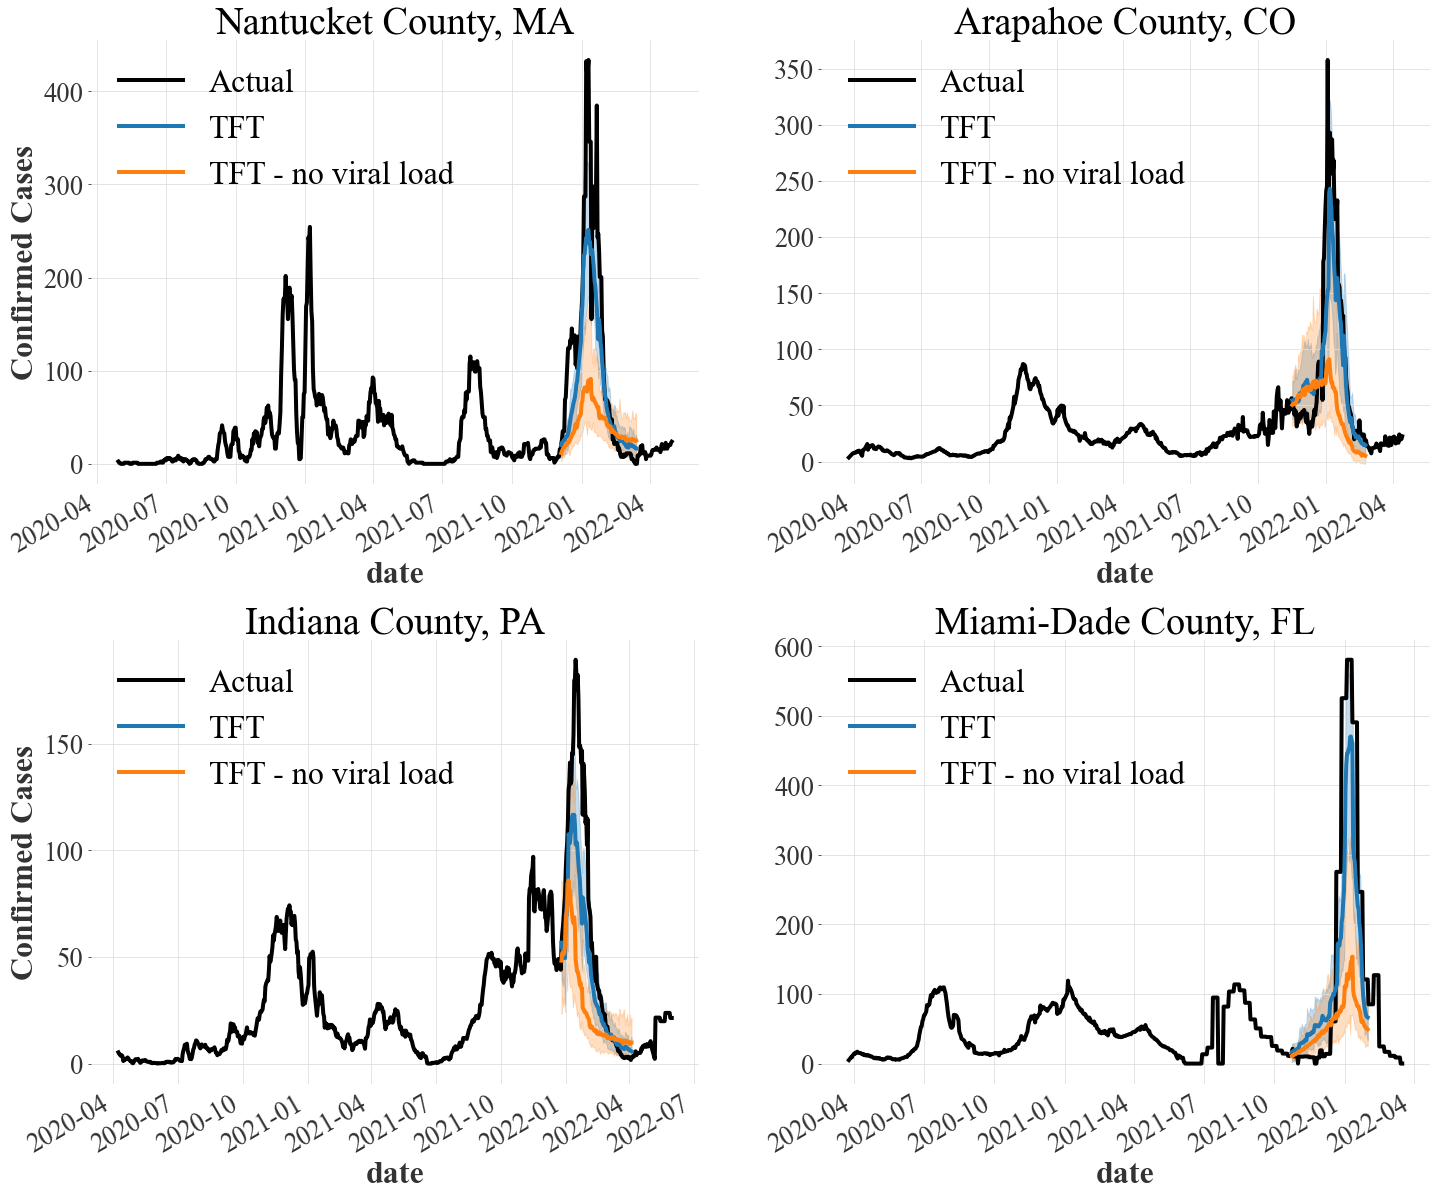

In [24]:
#- Test

n_days_pred = 100
n_samples = 200
low_q = 0.05
high_q = 0.95

fig=plt.figure(figsize=[24, 20])
plt.rcParams.update({'font.family':'times new roman', 'font.size': 32, 'font.weight':'normal'})

for j, i in enumerate([0, 3, 5, 7]):
    axis = fig.add_subplot(2,2,j+1)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=0.85, wspace=None, hspace=0.35)
    
    pred_tft = tft.predict(n_days_pred, series=counties_instances[i].cases_scaled_val, past_covariates=past_only_covar_ts[i], future_covariates=fut_covar_ts[i], num_samples=n_samples)
    pred_tft_noV = tft_wo_V.predict(n_days_pred, series=counties_instances[i].cases_scaled_val, future_covariates=fut_covar_ts[i], num_samples=n_samples)
    
    counties_instances[i].cases_scalers.inverse_transform(counties_instances[i].cases_scaled).plot(label="Actual", ax=axis, linewidth=4, c='k')
    counties_instances[i].cases_scalers.inverse_transform(pred_tft).plot(label="TFT", low_quantile=low_q, high_quantile=high_q, c='tab:blue', ax=axis, linewidth=4)
    counties_instances[i].cases_scalers.inverse_transform(pred_tft_noV).plot(label="TFT - no viral load", low_quantile=low_q, high_quantile=high_q, c='tab:orange', ax=axis, linewidth=4)
    
    print('TFT - SMAPE: ', smape_calc(counties_instances[i].cases_scaled_test, pred_tft, counties_instances[i].cases_scalers))
    print('TFT no viral - SMAPE: ', smape_calc(counties_instances[i].cases_scaled_test, pred_tft_noV, counties_instances[i].cases_scalers))
    
    axis.legend()
    axis.set_title(counties_instances[i].county)
    
    if j%2 == 0:
        axis.set_ylabel('Confirmed Cases')

# plt.savefig('./figs/TFT/Jan-10/TFT-noTFT-comp.png', bbox_inches='tight', dpi=400)
plt.show()

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

DeepTCN - SMAPE:  44.80878574071799
DeepTCN no viral - SMAPE:  93.41321522193424


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

DeepTCN - SMAPE:  24.224569875391197
DeepTCN no viral - SMAPE:  65.64560569404486


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

DeepTCN - SMAPE:  56.96779920144285
DeepTCN no viral - SMAPE:  122.40856081462475


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

DeepTCN - SMAPE:  81.58941403623254
DeepTCN no viral - SMAPE:  97.9396906179023


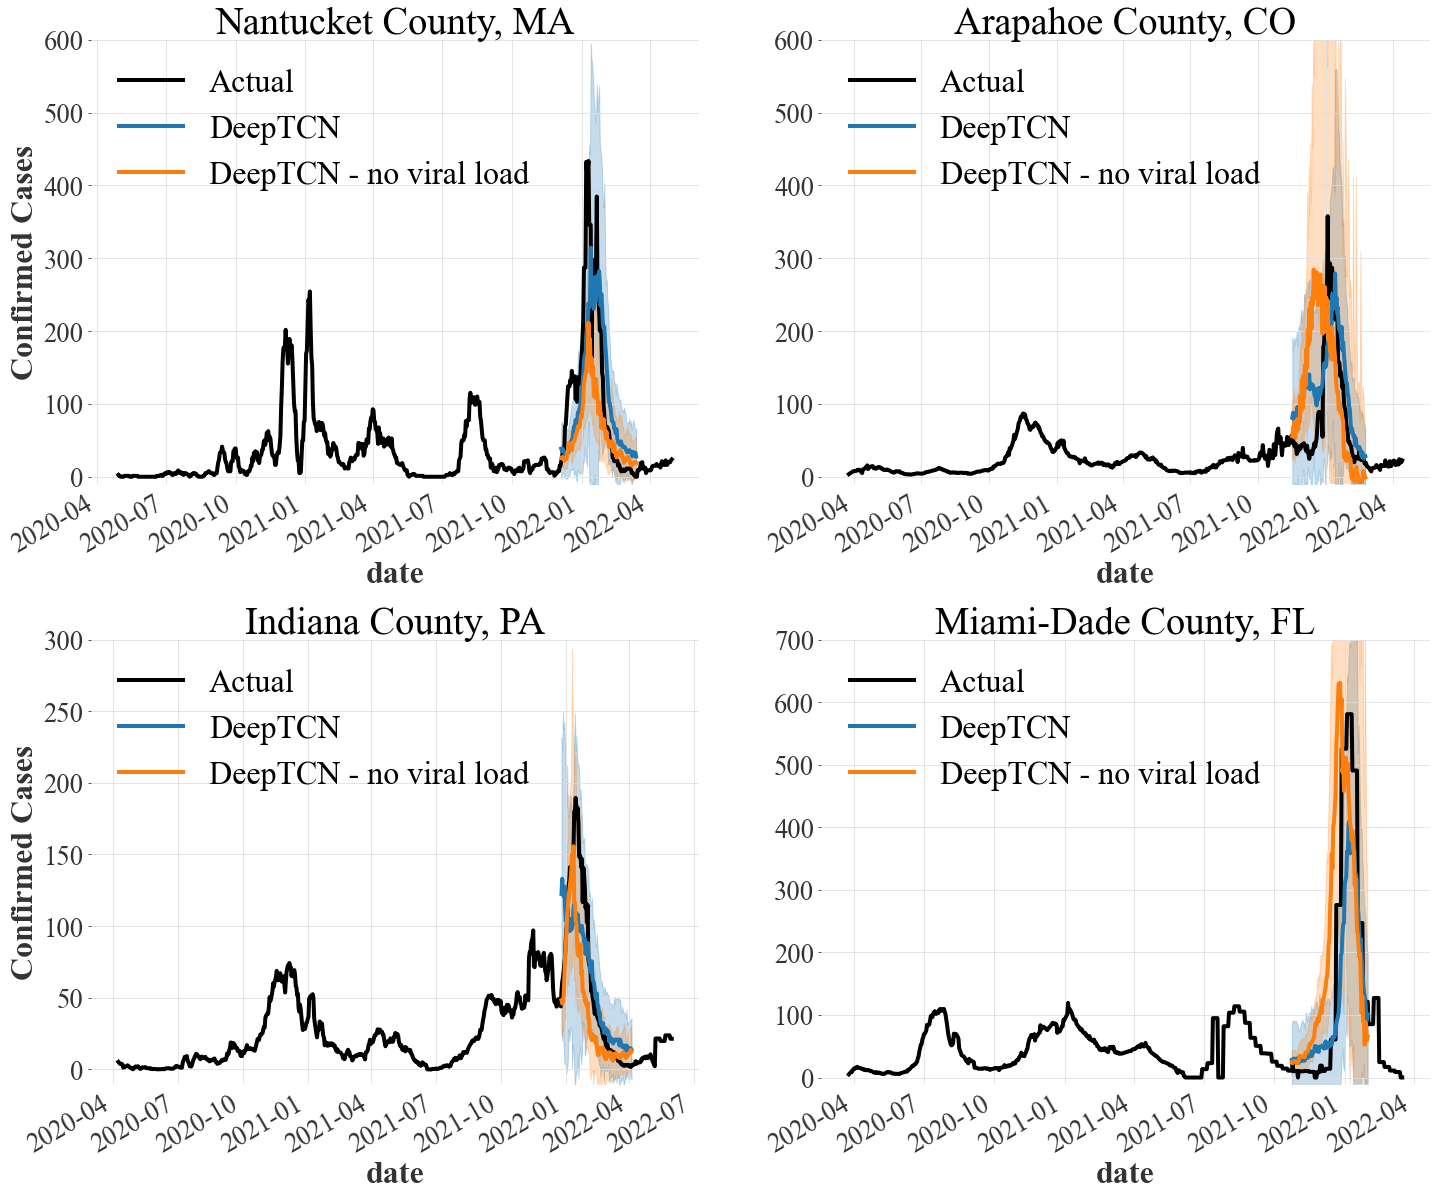

In [25]:
n_days_pred = 100
n_samples = 200
low_q = 0.05
high_q = 0.95
max_y = [600, 600, 300, 700]

fig=plt.figure(figsize=[24, 20])
plt.rcParams.update({'font.family':'times new roman', 'font.size': 32, 'font.weight':'normal'})

for j, i in enumerate([0, 3, 5, 7]):
    axis = fig.add_subplot(2,2,j+1)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=0.85, wspace=None, hspace=0.35)
    
    pred_deeptcn = deeptcn.predict(n_days_pred, series=counties_instances[i].cases_scaled_val, past_covariates=past_covar_ts[i], num_samples=n_samples)
    pred_deeptcn_wo_V = deeptcn_wo_V.predict(n_days_pred, series=counties_instances[i].cases_scaled_val, past_covariates=fut_covar_ts[i], num_samples=n_samples)
    
    counties_instances[i].cases_scalers.inverse_transform(counties_instances[i].cases_scaled).plot(label="Actual", ax=axis, linewidth=4, c='k', ylim=[-10, max_y[j]])
    counties_instances[i].cases_scalers.inverse_transform(pred_deeptcn).plot(label="DeepTCN", low_quantile=low_q, high_quantile=high_q, c='tab:blue', ax=axis, linewidth=4, ylim=[-10, max_y[j]])
    counties_instances[i].cases_scalers.inverse_transform(pred_deeptcn_wo_V).plot(label="DeepTCN - no viral load", low_quantile=low_q, high_quantile=high_q, c='tab:orange', ax=axis, linewidth=4, ylim=[-10, max_y[j]])
    
    print('DeepTCN - SMAPE: ', smape_calc(counties_instances[i].cases_scaled_test, pred_tft, counties_instances[i].cases_scalers))
    print('DeepTCN no viral - SMAPE: ', smape_calc(counties_instances[i].cases_scaled_test, pred_tft_noV, counties_instances[i].cases_scalers))
    
    axis.legend(loc='upper left')
    axis.set_title(counties_instances[i].county)
    
    if j%2 == 0:
        axis.set_ylabel('Confirmed Cases')

# plt.savefig('./figs/TFT/Jan-10/TCN-noTCN-comp.png', bbox_inches='tight', dpi=400)
plt.show()

## Backtesting

Despite the raw prediction, backtesting shifts the look-back window past the training period intead of prediction the entire test period at once. It is a more realistic evaluation of the model with the availability of new data. **It is our selected method for evaluating the models and making predictions and producing results for the [paper](https://arxiv.org/abs/2212.08798)**

In [27]:
params = {'hr': 10, 'strd': 10, 'start_ratio': 0.8, 'n_samples': 200, 'low_q': 0.05, 'high_q': 0.95, 'is_retrain':False}

hr = params['hr']
strd = params['strd']
start_ratio = params['start_ratio']
n_samples = params['n_samples']
low_q = params['low_q']
high_q = params['high_q']
is_retrain = params['is_retrain']
    
mae_dict      = {'DeepTCN':[], 'DeepTCN_wo_V':[], 'TFT':[], 'TFT_wo_V':[]}
cov_dict      = {'DeepTCN':[], 'DeepTCN_wo_V':[], 'TFT':[], 'TFT_wo_V':[]}
smape_dict    = {'DeepTCN':[], 'DeepTCN_wo_V':[], 'TFT':[], 'TFT_wo_V':[]}

DeepTCN_backtest     = []
DeepTCN_noV_backtest = []
TFT_backtest         = []
TFT_noV_backtest     = []

for k in range(len(fut_covar_ts)):
    print('{},\t{}/{}'.format(counties_instances[k].county, k+1, len(fut_covar_ts)))
    
    DeepTCN_backtest.append(deeptcn.historical_forecasts(
        series=counties_instances[k].cases_scaled,
        past_covariates=past_covar_ts[k],
        num_samples=n_samples,
        start=start_ratio,
        forecast_horizon=hr,
        stride=strd,
        retrain=is_retrain,
        verbose=False,
    ))
    print('DeepTCN with viral load is done!')

    DeepTCN_noV_backtest.append(deeptcn_wo_V.historical_forecasts(
        series=counties_instances[k].cases_scaled,
        past_covariates=fut_covar_ts[k],
        num_samples=n_samples,
        start=start_ratio,
        forecast_horizon=hr,
        stride=strd,
        retrain=is_retrain,
        verbose=False,
    ))
    print('DeepTCN without viral is done!')

    backtest_tft = tft.historical_forecasts(
        series=counties_instances[k].cases_scaled,
        future_covariates=fut_covar_ts[k],
        past_covariates=past_only_covar_ts[k],
        start=start_ratio,
        num_samples=n_samples,
        forecast_horizon=hr,
        stride=strd,
        overlap_end=False,
        last_points_only=False,
        retrain=is_retrain,
        verbose=False,
    )
    TFT_backtest.append(concatenate(backtest_tft, ignore_time_axis=True))
    print('TFT with viral load is done!')

    backtest_tft = tft_wo_V.historical_forecasts(
        series=counties_instances[k].cases_scaled,
        future_covariates=fut_covar_ts[k],
        start=start_ratio,
        num_samples=n_samples,
        forecast_horizon=hr,
        stride=strd,
        overlap_end=False,
        last_points_only=False,
        retrain=is_retrain,
        verbose=False,
    )
    TFT_noV_backtest.append(concatenate(backtest_tft, ignore_time_axis=True))
    print('TFT without viral load is done!')

Nantucket County, MA,	1/13


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

DeepTCN with viral load is done!


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

DeepTCN without viral is done!


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

TFT with viral load is done!


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

TFT without viral load is done!
Dauphin County, PA,	2/13


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

DeepTCN with viral load is done!


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

DeepTCN without viral is done!


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

TFT with viral load is done!


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

TFT without viral load is done!
Elko County, NV,	3/13


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

DeepTCN with viral load is done!


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

DeepTCN without viral is done!


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

TFT with viral load is done!


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

TFT without viral load is done!
Arapahoe County, CO,	4/13


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

DeepTCN with viral load is done!


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

DeepTCN without viral is done!


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

TFT with viral load is done!


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

TFT without viral load is done!
Erie County, PA,	5/13


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

DeepTCN with viral load is done!


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

DeepTCN without viral is done!


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

TFT with viral load is done!


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

TFT without viral load is done!
Indiana County, PA,	6/13


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

DeepTCN with viral load is done!


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

DeepTCN without viral is done!


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

TFT with viral load is done!


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

TFT without viral load is done!
Jefferson County, KY,	7/13


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

DeepTCN with viral load is done!


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

DeepTCN without viral is done!


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

TFT with viral load is done!


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

TFT without viral load is done!
Miami-Dade County, FL,	8/13


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

DeepTCN with viral load is done!


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

DeepTCN without viral is done!


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

TFT with viral load is done!


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

TFT without viral load is done!
Suffolk County, MA,	9/13


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

DeepTCN with viral load is done!


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

DeepTCN without viral is done!


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

TFT with viral load is done!


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

TFT without viral load is done!
Essex County, MA,	10/13


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

DeepTCN with viral load is done!


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

DeepTCN without viral is done!


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

TFT with viral load is done!


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

TFT without viral load is done!
Hampshire County, MA,	11/13


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

DeepTCN with viral load is done!


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

DeepTCN without viral is done!


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

TFT with viral load is done!


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

TFT without viral load is done!
Union County, NJ,	12/13


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

DeepTCN with viral load is done!


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

DeepTCN without viral is done!


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

TFT with viral load is done!


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

TFT without viral load is done!
Lake County, IN,	13/13


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

DeepTCN with viral load is done!


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

DeepTCN without viral is done!


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

TFT with viral load is done!


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

TFT without viral load is done!


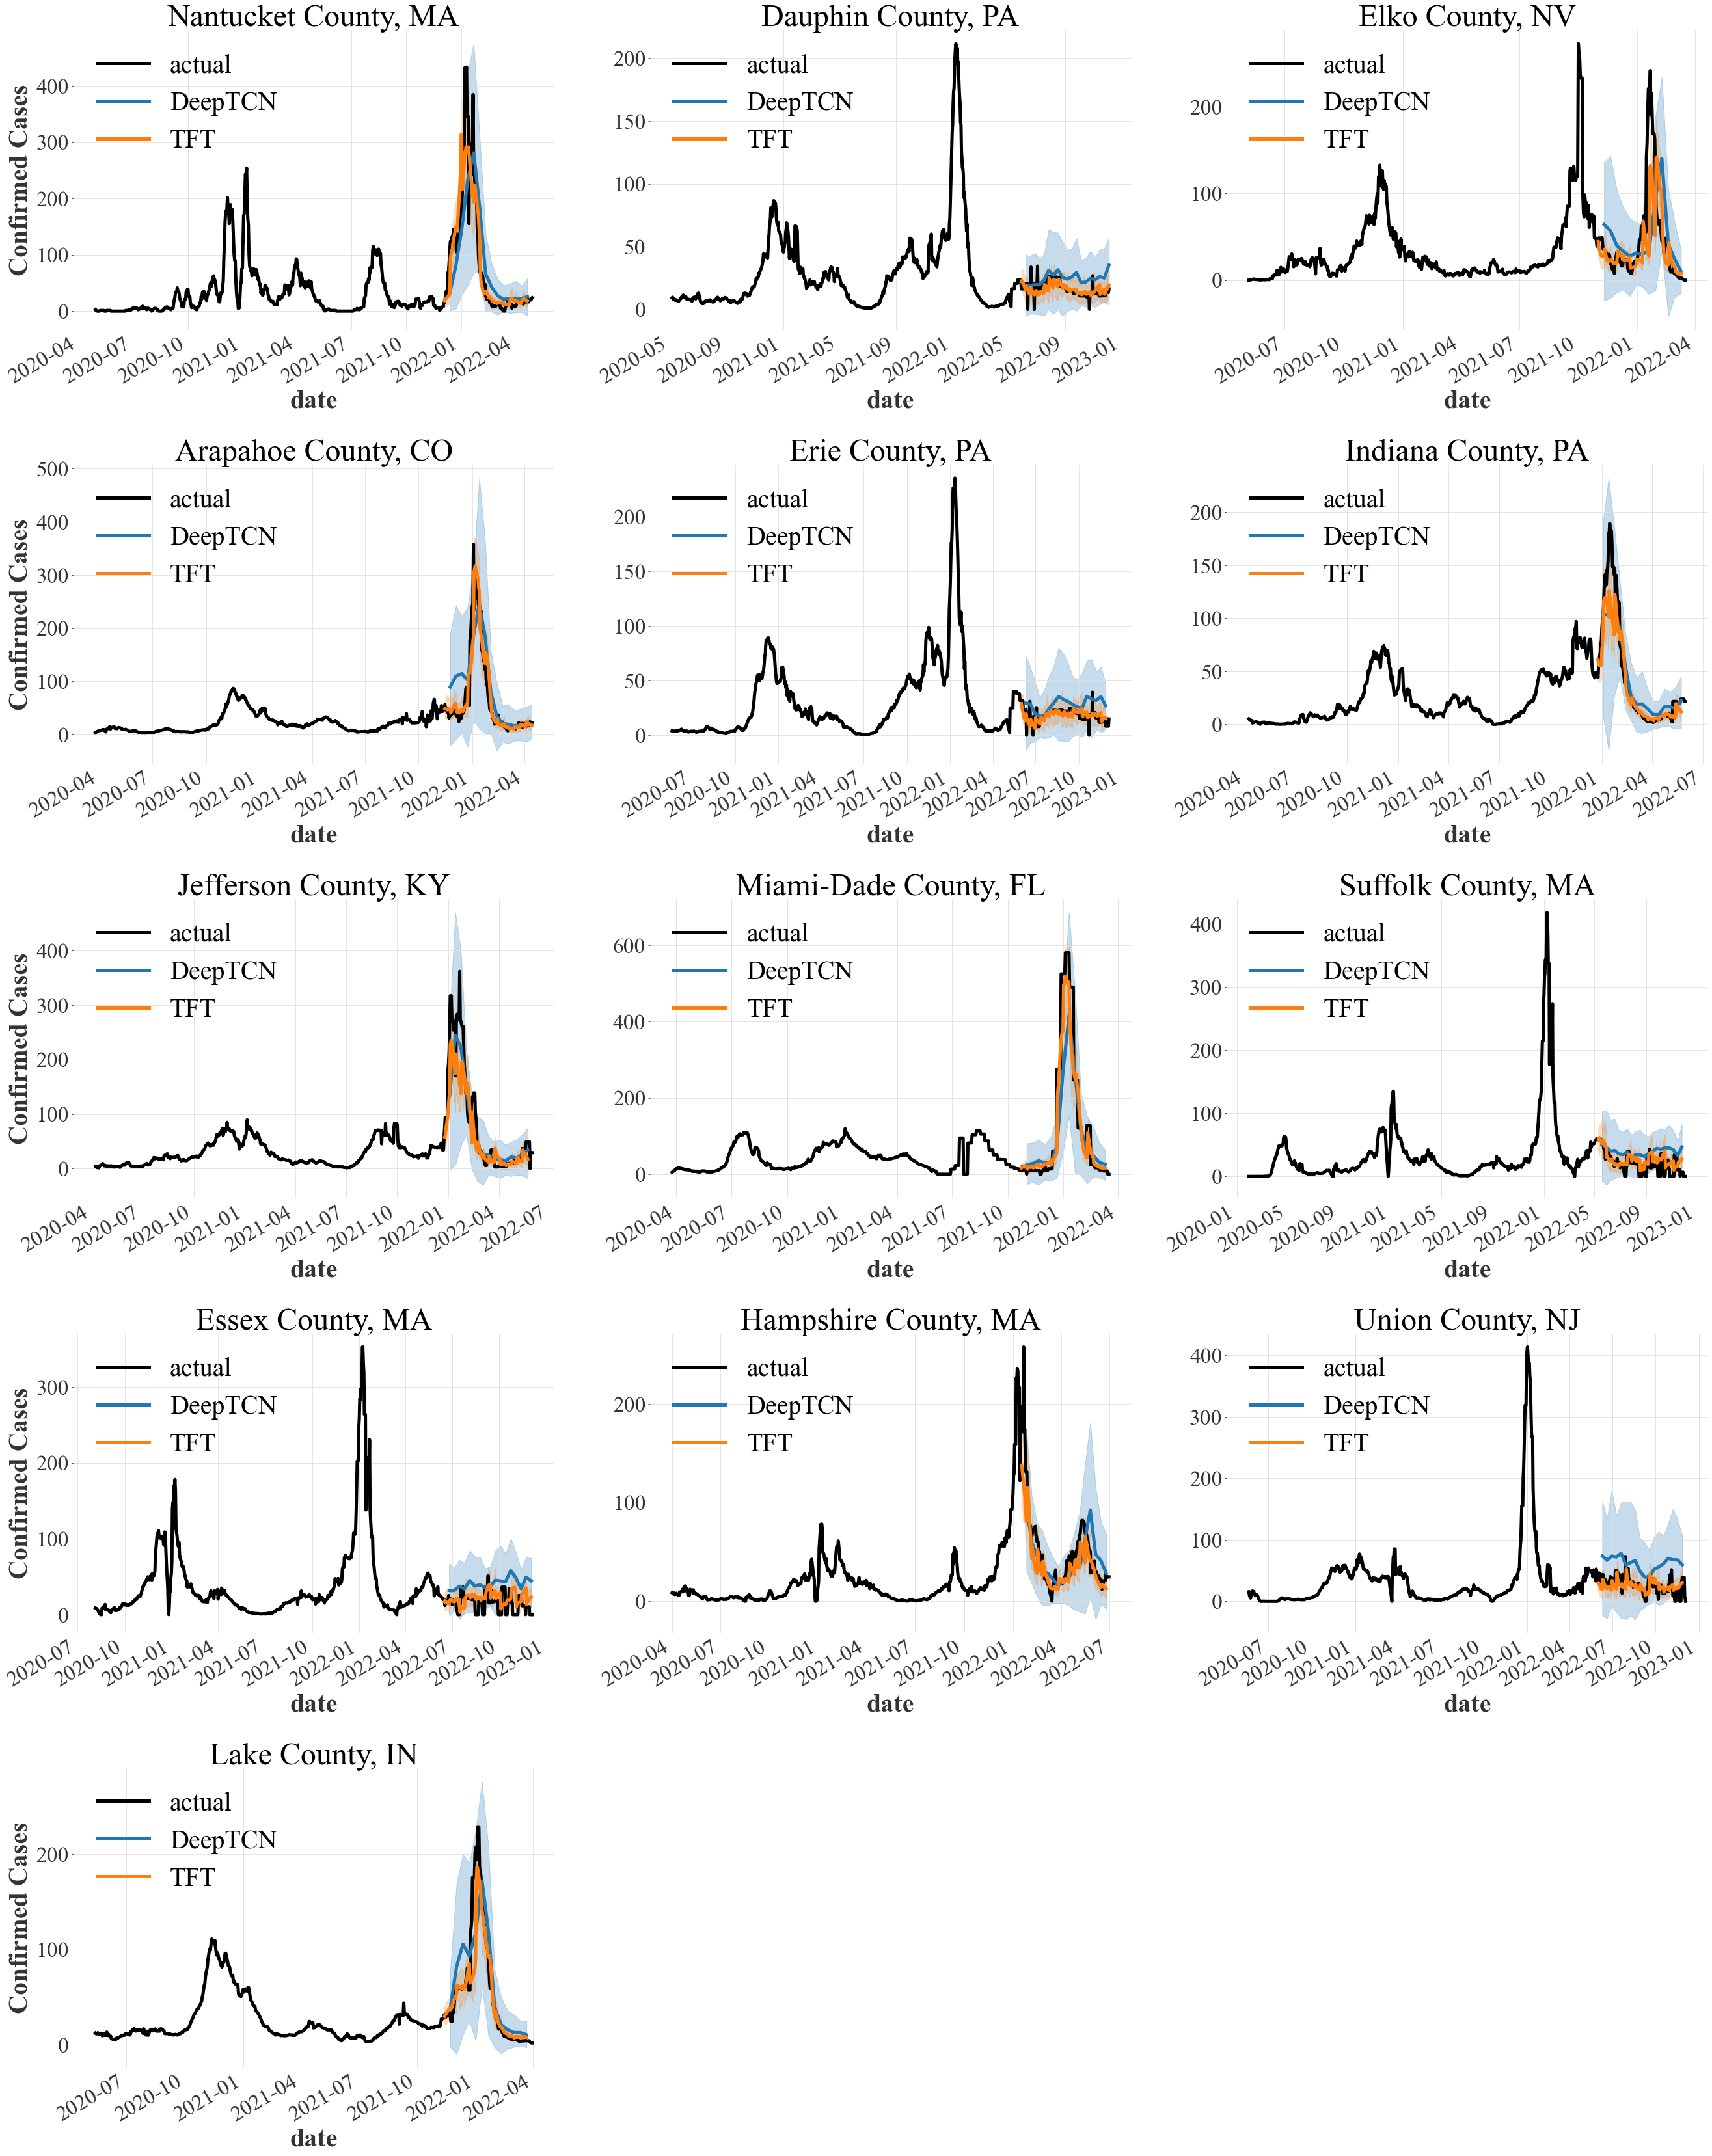

In [28]:
fig=plt.figure(figsize=[45, 60])
plt.rcParams.update({'font.family':'times new roman', 'font.size': 40, 'font.weight':'normal'})

for i in range(13):
    axis = fig.add_subplot(5,3,i+1)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=0.85, wspace=None, hspace=0.45)
    
    counties_instances[i].cases_scalers.inverse_transform(counties_instances[i].cases_scaled).plot(label="actual", ax=axis, linewidth=5)
    counties_instances[i].cases_scalers.inverse_transform(DeepTCN_backtest[i]).plot(label="DeepTCN", low_quantile=low_q, high_quantile=high_q, c='tab:blue', ax=axis, linewidth=5)
    counties_instances[i].cases_scalers.inverse_transform(TFT_backtest[i]).plot(label="TFT", low_quantile=low_q, high_quantile=high_q, c='tab:orange', ax=axis, linewidth=5)
    
    axis.legend()
    axis.set_title(counties_instances[i].county)
    
    if i%3 == 0:
        axis.set_ylabel('Confirmed Cases')

# plt.savefig('./figs/TFT/Jan-10/backtest_ALL_3*5.png', bbox_inches='tight', dpi=200)
plt.show()

## Model Evaluation

We use three evaluation metrics, mean absolute error (MAE), symmetric mean absolute percentage error (SMAPE), and coefficient of variation (CV). We calculate them for training counties and holdout counties separately.

### Holdout Counties

In [33]:
mae_dict      = {'DeepTCN':[], 'DeepTCN_wo_V':[], 'TFT':[], 'TFT_wo_V':[]}
cov_dict      = {'DeepTCN':[], 'DeepTCN_wo_V':[], 'TFT':[], 'TFT_wo_V':[]}
smape_dict    = {'DeepTCN':[], 'DeepTCN_wo_V':[], 'TFT':[], 'TFT_wo_V':[]}

# for k in range(len(fut_covar_ts)):
for k in range(11,13):
    
    target_county = counties_instances[k]
        
    smape_dict['DeepTCN'].append(smape_calc(DeepTCN_backtest[k], target_county.cases_scaled, target_county.cases_scalers))        
    smape_dict['DeepTCN_wo_V'].append(smape_calc(DeepTCN_noV_backtest[k], target_county.cases_scaled, target_county.cases_scalers))
    smape_dict['TFT'].append(smape_calc(TFT_backtest[k], target_county.cases_scaled, target_county.cases_scalers))
    smape_dict['TFT_wo_V'].append(smape_calc(TFT_noV_backtest[k], target_county.cases_scaled, target_county.cases_scalers))

    mae_dict['DeepTCN'].append(mae_calc(DeepTCN_backtest[k], target_county.cases_scaled, target_county.cases_scalers))        
    mae_dict['DeepTCN_wo_V'].append(mae_calc(DeepTCN_noV_backtest[k], target_county.cases_scaled, target_county.cases_scalers))
    mae_dict['TFT'].append(mae_calc(TFT_backtest[k], target_county.cases_scaled, target_county.cases_scalers))
    mae_dict['TFT_wo_V'].append(mae_calc(TFT_noV_backtest[k], target_county.cases_scaled, target_county.cases_scalers))

    cov_dict['DeepTCN'].append(cov_calc(DeepTCN_backtest[k], target_county.cases_scaled, target_county.cases_scalers))        
    cov_dict['DeepTCN_wo_V'].append(cov_calc(DeepTCN_noV_backtest[k], target_county.cases_scaled, target_county.cases_scalers))
    cov_dict['TFT'].append(cov_calc(TFT_backtest[k], target_county.cases_scaled, target_county.cases_scalers))
    cov_dict['TFT_wo_V'].append(cov_calc(TFT_noV_backtest[k], target_county.cases_scaled, target_county.cases_scalers))


cols=['Metric', 'DeepTCN', 'DeepTCN_wo_V', 'TFT', 'TFT_wo_V']
Models_eval = pd.DataFrame(columns=cols)

Models_eval['Metric'] = ['mae', 'cov', 'smape']

for i in cols[1:]:
    Models_eval.loc[0,i] = round(np.mean(mae_dict[i]), 3)
    Models_eval.loc[1,i] = round(np.mean(cov_dict[i]), 3)
    Models_eval.loc[2,i] = round(np.mean(smape_dict[i]), 3)

print('Holdout Counties:')
Models_eval

Holdout Counties:


,Metric,DeepTCN,DeepTCN_wo_V,TFT,TFT_wo_V
0,mae,28.324,20.733,11.321,12.531
1,cov,110.447,91.737,63.196,70.615
2,smape,63.937,49.721,35.402,38.843


### Training Counties

In [34]:
mae_dict      = {'DeepTCN':[], 'DeepTCN_wo_V':[], 'TFT':[], 'TFT_wo_V':[]}
cov_dict      = {'DeepTCN':[], 'DeepTCN_wo_V':[], 'TFT':[], 'TFT_wo_V':[]}
smape_dict    = {'DeepTCN':[], 'DeepTCN_wo_V':[], 'TFT':[], 'TFT_wo_V':[]}

# for k in range(len(fut_covar_ts)):
for k in range(11):
    
    target_county = counties_instances[k]
        
    smape_dict['DeepTCN'].append(smape_calc(DeepTCN_backtest[k], target_county.cases_scaled, target_county.cases_scalers))        
    smape_dict['DeepTCN_wo_V'].append(smape_calc(DeepTCN_noV_backtest[k], target_county.cases_scaled, target_county.cases_scalers))
    smape_dict['TFT'].append(smape_calc(TFT_backtest[k], target_county.cases_scaled, target_county.cases_scalers))
    smape_dict['TFT_wo_V'].append(smape_calc(TFT_noV_backtest[k], target_county.cases_scaled, target_county.cases_scalers))

    mae_dict['DeepTCN'].append(mae_calc(DeepTCN_backtest[k], target_county.cases_scaled, target_county.cases_scalers))        
    mae_dict['DeepTCN_wo_V'].append(mae_calc(DeepTCN_noV_backtest[k], target_county.cases_scaled, target_county.cases_scalers))
    mae_dict['TFT'].append(mae_calc(TFT_backtest[k], target_county.cases_scaled, target_county.cases_scalers))
    mae_dict['TFT_wo_V'].append(mae_calc(TFT_noV_backtest[k], target_county.cases_scaled, target_county.cases_scalers))

    cov_dict['DeepTCN'].append(cov_calc(DeepTCN_backtest[k], target_county.cases_scaled, target_county.cases_scalers))        
    cov_dict['DeepTCN_wo_V'].append(cov_calc(DeepTCN_noV_backtest[k], target_county.cases_scaled, target_county.cases_scalers))
    cov_dict['TFT'].append(cov_calc(TFT_backtest[k], target_county.cases_scaled, target_county.cases_scalers))
    cov_dict['TFT_wo_V'].append(cov_calc(TFT_noV_backtest[k], target_county.cases_scaled, target_county.cases_scalers))


cols=['Metric', 'DeepTCN', 'DeepTCN_wo_V', 'TFT', 'TFT_wo_V']
Models_eval = pd.DataFrame(columns=cols)

Models_eval['Metric'] = ['mae', 'cov', 'smape']

for i in cols[1:]:
    Models_eval.loc[0,i] = round(np.mean(mae_dict[i]), 3)
    Models_eval.loc[1,i] = round(np.mean(cov_dict[i]), 3)
    Models_eval.loc[2,i] = round(np.mean(smape_dict[i]), 3)

print('Training Counties:')
Models_eval

Training Counties:


,Metric,DeepTCN,DeepTCN_wo_V,TFT,TFT_wo_V
0,mae,26.646,25.458,16.871,18.026
1,cov,107.144,104.21,75.86,82.559
2,smape,59.572,58.319,42.677,46.651


## Error per County

In [36]:
mae_df = pd.DataFrame(mae_dict)
mae_df['metric'] = 'mae'
mae_df['county'] = county_names[:11]

cov_df = pd.DataFrame(cov_dict)
cov_df['metric'] = 'cov'
cov_df['county'] = county_names[:11]

smape_df = pd.DataFrame(smape_dict)
smape_df['metric'] = 'smape'
smape_df['county'] = county_names[:11]

my_dat = pd.concat([mae_df, cov_df, smape_df], axis=0, ignore_index=True)
my_dat

my_dat = my_dat.melt(id_vars=['metric', 'county'], value_vars=['DeepTCN', 'DeepTCN_wo_V', 'TFT', 'TFT_wo_V'])

my_dat.loc[my_dat['variable']=='TFT_wo_V', 'variable'] = 'TFT - w/o viral load'
my_dat.loc[my_dat['variable']=='DeepTCN_wo_V', 'variable'] = 'DeepTCN - w/o viral load'
my_dat

,metric,county,variable,value
0,mae,Nantucket,DeepTCN,41.832894
1,mae,Dauphin,DeepTCN,8.422468
2,mae,Elko,DeepTCN,36.518592
3,mae,Arapahoe,DeepTCN,36.565181
4,mae,Erie,DeepTCN,10.012542
...,...,...,...,...
127,smape,Jefferson,TFT - w/o viral load,64.834075
128,smape,Miami-Dade,TFT - w/o viral load,40.955048
129,smape,Suffolk,TFT - w/o viral load,74.113281
130,smape,Essex,TFT - w/o viral load,91.613568


### MAE

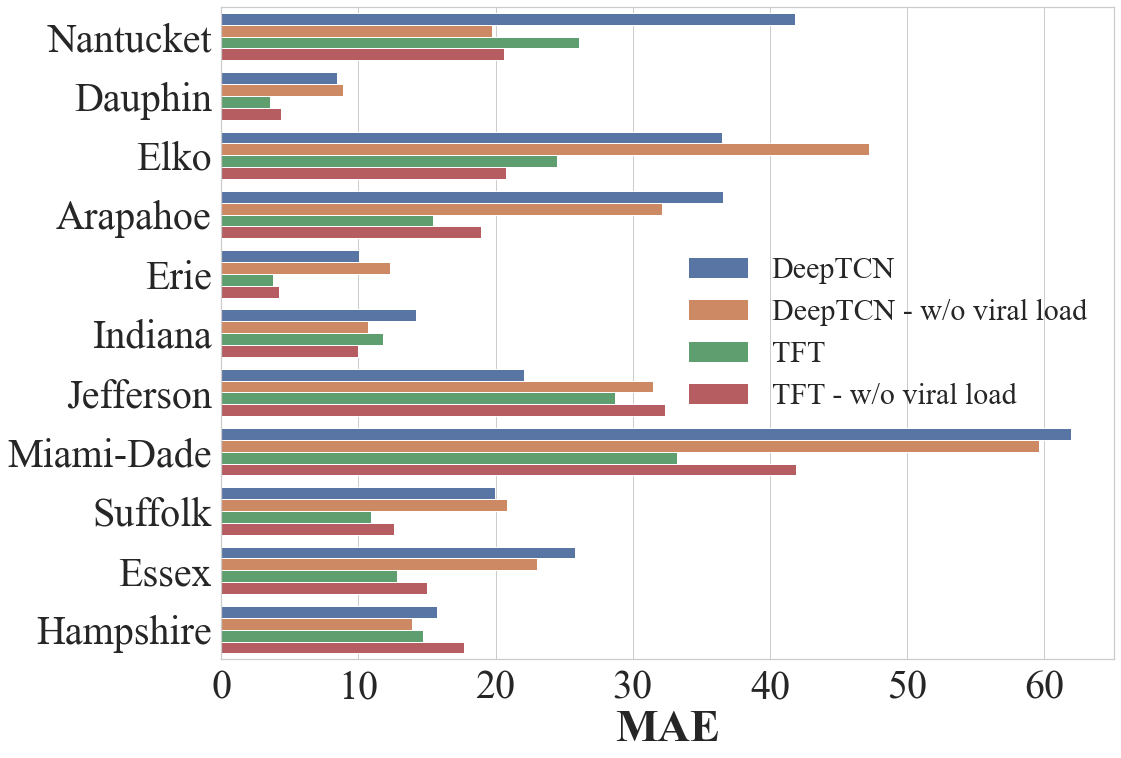

In [38]:
import seaborn as sns

plt.figure(figsize=(16,12))
sns.set_theme(style="whitegrid", rc={'font.family':'times new roman', 'font.weight':'normal'})

b = sns.barplot(data=my_dat.loc[my_dat['metric']=='mae'], y='county', x='value', hue='variable')

# b.axes.set_title("MAE",fontsize=50)
b.set_xlabel("MAE",fontsize=45)
b.set_ylabel("")
b.legend(fontsize=30)
b.tick_params(labelsize=40, rotation=0)

### SMAPE

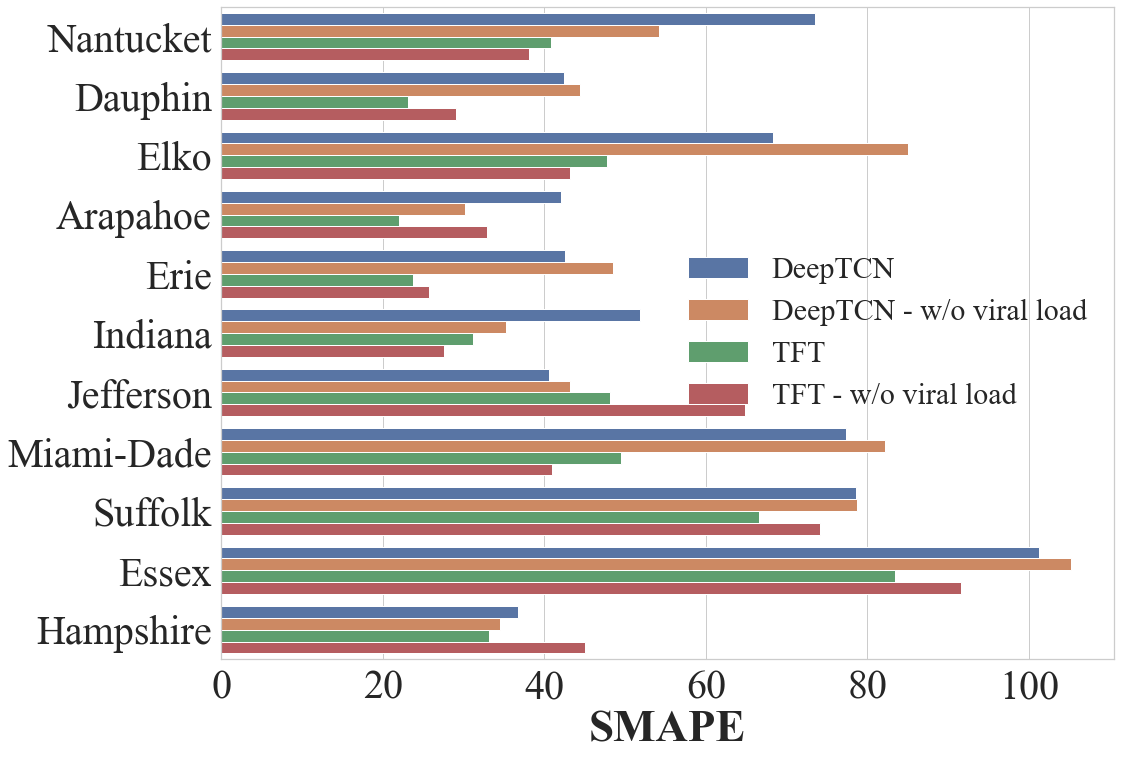

In [40]:
plt.figure(figsize=(16,12))
sns.set_theme(style="whitegrid", rc={'font.family':'times new roman', 'font.weight':'normal'})

b = sns.barplot(data=my_dat.loc[my_dat['metric']=='smape'], y='county', x='value', hue='variable')

# b.axes.set_title("MAE",fontsize=50)
b.set_xlabel("SMAPE",fontsize=45)
b.set_ylabel("")
b.legend(fontsize=30)
b.tick_params(labelsize=40, rotation=0)

### CV

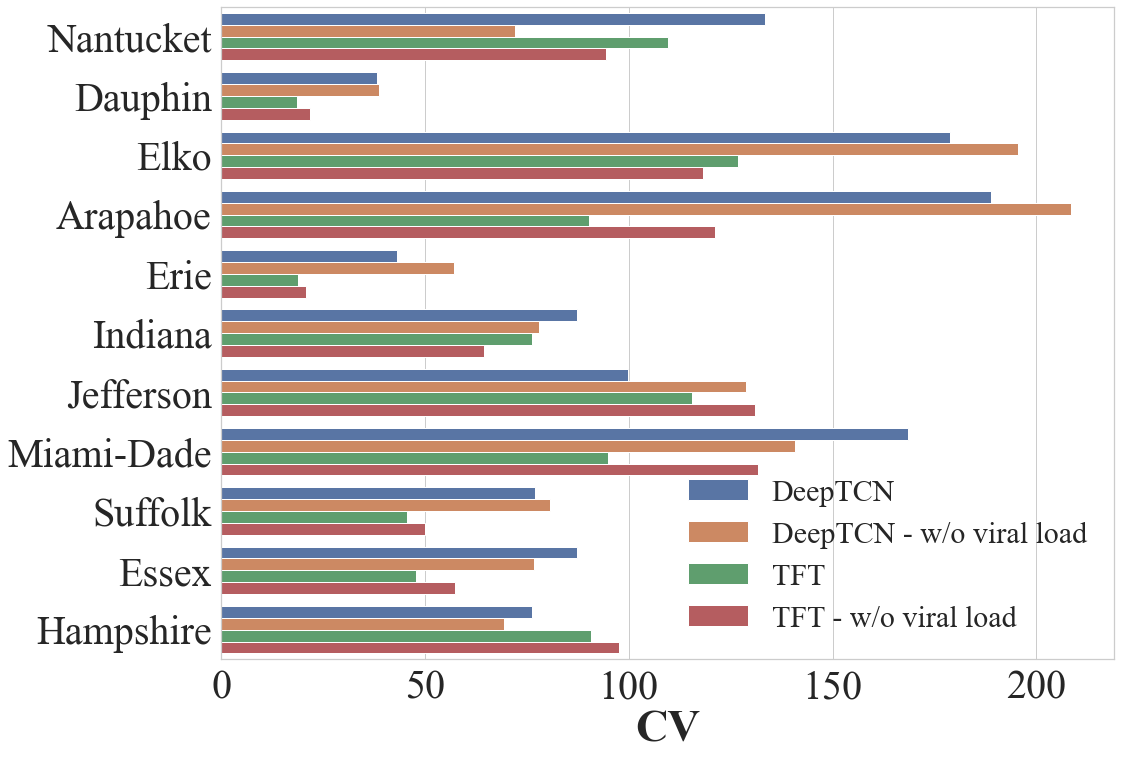

In [41]:
plt.figure(figsize=(16,12))
sns.set_theme(style="whitegrid", rc={'font.family':'times new roman', 'font.weight':'normal'})

b = sns.barplot(data=my_dat.loc[my_dat['metric']=='cov'], y='county', x='value', hue='variable')

# b.axes.set_title("MAE",fontsize=50)
b.set_xlabel("CV",fontsize=45)
b.set_ylabel("")
b.legend(fontsize=30)
b.tick_params(labelsize=40, rotation=0)